2025-03-31 11:40:00.719203: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/dan/anaconda3/envs/networks/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1743435602.658006   23222 gpu_device.cc:2340] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Ski

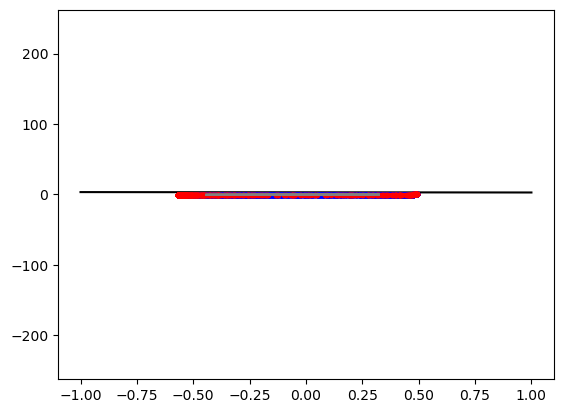

In [14]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import os

import tensorflow as tf
from tensorflow import keras
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import keras as K
import scipy



def attention_fakedata():
    rng = np.random.default_rng(42)
    ratio = 11.0

    # Generate synthetic data with 
    n_samples = 100000
    n_pos = int(n_samples / (ratio + 1))  # Calculate number of positive samples
    n_neg = n_samples - n_pos  # Remaining are negative samples

    # Create labels array with the correct ratio
    labels = np.concatenate([np.zeros(n_neg), np.ones(n_pos)])

    # Shuffle the labels
    rng.shuffle(labels)

    # Create a DataFrame with the synthetic data
    raw_df = pd.DataFrame({'soz': labels})

    # Using boolean indexing:
    mask0 = raw_df['soz'] == 0
    mask1 = raw_df['soz'] == 1

    raw_df.loc[mask0, 'f1'] = rng.normal(6, 0.3, size=mask0.sum())
    raw_df.loc[mask1, 'f1'] = rng.gamma(1, .11, size=mask1.sum())


    raw_df['f2'] = rng.normal(10, 5, size=n_samples)

    return raw_df

raw_df = attention_fakedata()

# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(raw_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('soz')).reshape(-1, 1)
bool_train_labels = train_labels[:, 0] != 0
val_labels = np.array(val_df.pop('soz')).reshape(-1, 1)
test_labels = np.array(test_df.pop('soz')).reshape(-1, 1)

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)


scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)


def get_decision_boundary(model):
    """ Function to return the x-y coodinates of the decision boundary given a model.
        This assumes the second to last hidden layer is a 2 hidden unit layer with a bias term
        and sigmoid activation on the last layer."""
    a = model.layers[-1].get_weights()[0][0][0]
    b = model.layers[-1].get_weights()[0][1][0]
    c = model.layers[-1].get_weights()[1][0]
    decision_x = np.linspace(-1,1,100)
    decision_y = (scipy.special.logit(.5)-c-a*decision_x)/b
    return decision_x, decision_y

def animate_model(model, n_frames=100):
    """ Function to animate a model's first n_frames epochs of training. """
    
    # Define necessary lines to plot a grid-- this will represent the vanilla "input space".
    grids = [np.column_stack((np.linspace(-1,1, 100), k*np.ones(100)/10.)) for k in range(-10,11)] +\
                [np.column_stack((k*np.ones(100)/10.,np.linspace(-1,1, 100))) for k in range(-10,11) ]

    # Define functions for the output of the 2-hidden unit layer. 
    # We assume this is the second to last layer
    f = K.Function(inputs = model.inputs, outputs = model.layers[-2].output)
    
    decision_x, decision_y = get_decision_boundary(model)

    # Plot the original space's deformation by the neural network and use it as the init()
    fig, ax = plt.subplots()

    orig_vals = f(inputs=[df[['x','y']].values])
    line, = ax.plot(decision_x,decision_y,color='black')
    lineb, = ax.plot(orig_vals.numpy()[indb,0], orig_vals.numpy()[indb,1], marker='.', color='b')
    liner, = ax.plot(orig_vals.numpy()[indr,0], orig_vals.numpy()[indr,1], marker='.', color='r')
    grid_lines = []

    for grid in grids:
        vals = np.array(grid)
        l, = ax.plot(vals[:,0],vals[:,1], color='grey', alpha=.5)
        grid_lines.append(l)

    all_lines = tuple([line, lineb, liner, *grid_lines])

    def animate(i):
        model.fit(df[['x','y']].values, df[['label']].values, epochs=1, batch_size=32, verbose=0)
        line.set_data(*get_decision_boundary(model))
        vals = f(inputs = [df[['x','y']].values])
        lineb.set_data(vals.numpy()[indb,0], vals.numpy()[indb,1])
        liner.set_data(vals.numpy()[indr,0], vals.numpy()[indr,1])

        for k in range(len(grid_lines)):
            ln = grid_lines[k]
            grid = grids[k]
            vals = f(inputs = [np.array(grid)])
            ln.set_data(vals.numpy()[:,0],vals.numpy()[:,1])

        return all_lines

    def init():
        line.set_ydata(np.ma.array(decision_x, mask=True))
        lineb.set_data(orig_vals.numpy()[indb,0],orig_vals.numpy()[indb,1])
        liner.set_data(orig_vals.numpy()[indr,0],orig_vals.numpy()[indr,1])
        for k in range(len(grid_lines)):
            ln = grid_lines[k]
            grid = grids[k]
            vals = f(inputs = [np.array(grid)])
            ln.set_data(vals.numpy()[:,0],vals.numpy()[:,1])
        return all_lines

    return animation.FuncAnimation(fig, animate, np.arange(1, n_frames), init_func=init,
                                  interval=100, blit=True)


from keras.models import Sequential
from keras.layers import Dense, Activation

df = train_df.rename(columns={'f1':'x', 'f2':'y'})
indb = train_labels[:,0]==0
indr = train_labels[:,0]==1
df['label'] = train_labels[:,0]


model = Sequential()
model.add(Dense(2, activation='tanh', input_dim=2))
model.add(Dense(2, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
sgd = keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=sgd,
              loss='mse',
              metrics=['accuracy'])

anim = animate_model(model)
HTML(anim.to_html5_video())